<center><h1>ЛР 5 - Условная оптимизация</h1><center>
<center>Леховицкий Дмитрий, ст. гр. ПМ-15-1<center>
<center>Вариант №7<center>

In [1]:
# uncomment if running via Jupyter Lab
# %matplotlib ipympl
# uncomment if running via Jupyter Notebook
% matplotlib notebook

import numpy as np
from numpy import array

import sys
sys.path.append('lib')
from plotting import plot_contours
from constraint import fmin_cutting_plane
from constraint import fmin_gradient_projection

def callback(x):
    global x_hist, y_hist
    x_hist = np.r_[x_hist, x[0]]
    y_hist = np.r_[y_hist, x[1]]

# Часть 1 - Метод отсекающих плоскостей (Келли)

## Постановка задачи

Рассматриваем задачу условной оптимизации, с линейной целевой функцией. Будем работать со следующим примером:

$$f(\mathbf{x}) = -x_1 - 0.7 x_2 + 15 \to \min_{x\in \Omega},$$
$$\Omega: 2x_1 - x_2 \leq 0; 3x_1^2 + x_2 \leq 1; x_1, x_2 \geq 0.$$

In [2]:
c = array([-1., -0.7])

def f(x):
    return -x[0] - 0.7*x[1] + 15

def g1(x): return 2*x[0] - x[1]
def jac_g1(x): return array([2, -1])
def g2(x): return 3*x[0]**2 + x[1] - 1
def jac_g2(x): return array([6*x[0], 1])
def g3(x): return -x[0]
def jac_g3(x): return array([-1, 0])
def g4(x): return -x[1]
def jac_g4(x): return array([0, -1])

def g(x): 
    return array([g1(x), g2(x), g3(x), g4(x)])

def jacg(x):
    return array([
        jac_g1(x).tolist(), jac_g2(x).tolist(),
        jac_g3(x).tolist(), jac_g4(x).tolist()])

constraints = [
    {'type': 'ineq', 'fun': g1, 'jac': jac_g1},
    {'type': 'ineq', 'fun': g2, 'jac': jac_g2},
    {'type': 'ineq', 'fun': g3, 'jac': jac_g3},
    {'type': 'ineq', 'fun': g4, 'jac': jac_g4},
]

In [3]:
delta = 0.005
x = np.arange(-delta, 1+2*delta, step=delta)
y = np.arange(-delta, 1+2*delta, step=delta)
xx, yy = np.meshgrid(x, y)

Построим линии уровня целевой функции и график допустимой области:

<IPython.core.display.Javascript object>


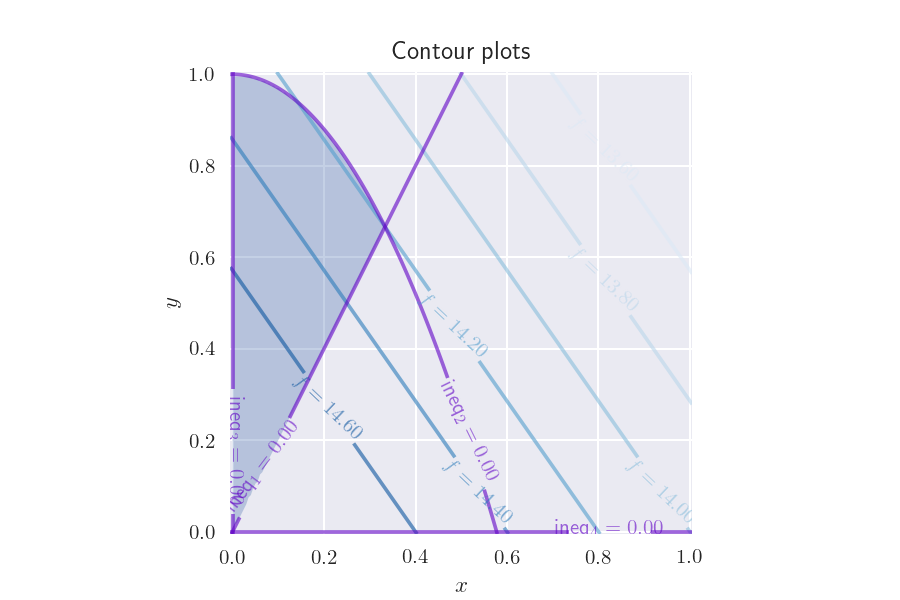

In [4]:
fig, ax = plot_contours(f, xx, yy, [13.6, 13.8, 14., 14.2, 14.4, 14.6], constraints)

## Метод отсекающих плоскостей 

Метод  отсекающих плоскостей заключается в том, что мы начинаем с самой простой возможной области $\Omega^{(0)}\supseteq \Omega$, имеющей вид прямоугольника, и постепенно срезаем её новыми плоскостями так, что в конечном счёте $\Omega^{(k)}\to\Omega, k\to\infty$. Целевую функцию не трогаем.

При этом на каждой итерации мы сталкиваемся с задачей линейного программирования, которая решается симплекс-методом. 

Отсекающие плоскости строятся следующим образом: 
1. Выбирается ограничение $g_i$, которое не выполняется больше всего (т.е., $i=\arg\max\limits_{i=\overline{1, k}} g_i(\mathbf{x}^{(k)})$). 
2. Проверяется, не удовлетворяет ли оно уже необходимой точности, если да, то итерационный процесс прекращается. Если же нет, то
3. Стоится отсекающая плоскость вида $g_i(\mathbf{x^{(k)}}) + \nabla g_i(\mathbf{x^{(k)}}) (\mathbf{x}-\mathbf{x}^{(k)}) \leq 0$.

Посмотрим, как метод работает на нашем примере.

In [5]:
x_hist = array([])
y_hist = array([])
res = fmin_cutting_plane(c, g, jacg, bounds=[(0., 1.), (0., 1.)], callback=callback)
print("Минимум функции: %.4f" % (res.fun + 15.))
print("Точка минимума: (%.3f, %.3f)" % tuple(res.x))
print("Количество итераций: %d" % res.nit)
print("Время выполнения:")
%timeit fmin_cutting_plane(c, g, jacg, bounds=[(0., 1.), (0., 1.)])

Минимум функции: 14.1805
Точка минимума: (0.234, 0.836)
Количество итераций: 6
Время выполнения:
24.6 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


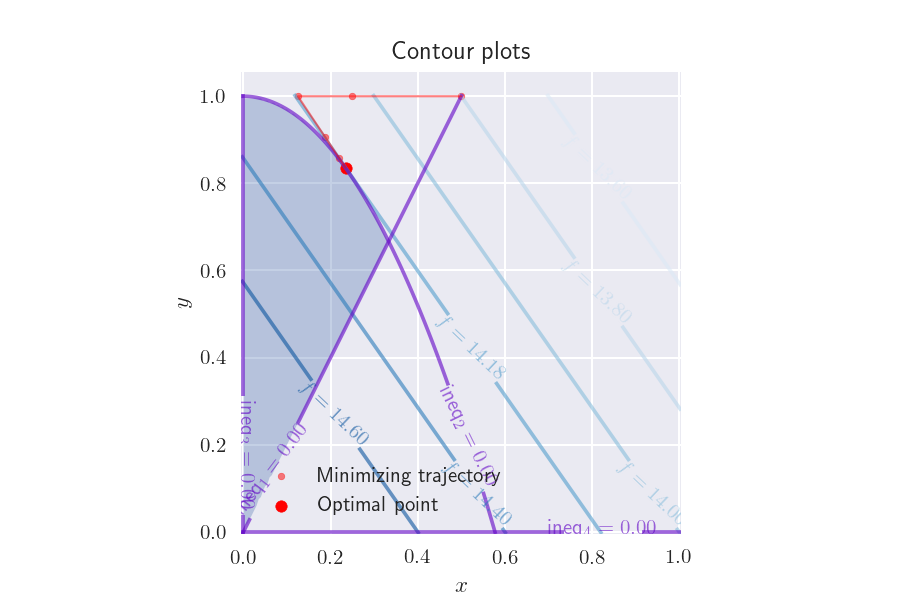

In [6]:
fig, ax = plot_contours(f, xx, yy, [13.6, 13.8, 14., res.fun+15, 14.4, 14.6], constraints)
ax.plot(x_hist, y_hist, c='r', linewidth=1, alpha=0.5)
ax.scatter(x_hist, y_hist, c='r', s=10, alpha=0.5, label='Minimizing trajectory')
ax.scatter(*res.x, c='r', s=30, label='Optimal point')
ax.legend();

# Часть 2 - метод проекций градиента (Розена)

## Постановка задачи

Перед нами стоит задача условной оптимизации, ограничения могут иметь тип как равенств, так и неравенств.

$$f(\mathbf{x}) = -4 x_1 - 8 x_2 + 2 x_1^2 +2 x_2^2 \to \min_{x\in \Omega},$$
$$\Omega: \begin{align}2\leq x_1 \leq 4,\\ 1\leq x_2 \leq 3.\end{align}$$

In [7]:
f = lambda x: -4*x[0] - 8*x[1] + 2*x[0]**2 + 2*x[1]**2
jacf = lambda x: array([4*x[0]-4, 4*x[1]-8])

constraints = [
    {'type': 'ineq', 'fun': lambda x: 2-x[0], 'jac': lambda x: array([-1,  0])},
    {'type': 'ineq', 'fun': lambda x: x[0]-4, 'jac': lambda x: array([ 1,  0])},
    {'type': 'ineq', 'fun': lambda x: 1-x[1], 'jac': lambda x: array([ 0, -1])},
    {'type': 'ineq', 'fun': lambda x: x[1]-3, 'jac': lambda x: array([ 0,  1])}    
]

In [8]:
delta = 0.005
x = np.arange(1-delta, 5+delta, delta)
y = np.arange( -delta, 4+delta, delta)
xx, yy = np.meshgrid(x, y)

Построим линии уровня целевой функции и график допустимой области:

<IPython.core.display.Javascript object>


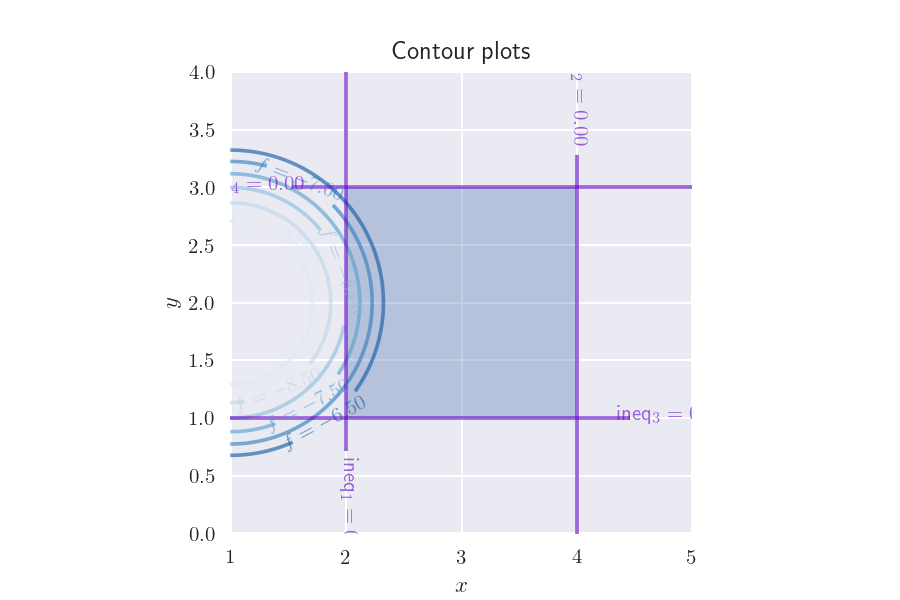

In [9]:
fig, ax = plot_contours(f, xx, yy, [-9, -8.5, -8, -7.5, -7, -6.5], constraints);

## Метод проекций градиента

Метод проекций градиента является модификацией метода нискорейшего спуска на случай задачи с ограничениями. Шаг на каждой итерации делается в направлении антиградиента, но в случае попытки выйти за допустимую область точка "проектируется обратно на неё". Шаг делается по следующей формуле:

$$\mathbf{x}^{(k+1)} = P_{\Omega}(\mathbf{x}^{(k)}-\alpha_k \nabla f(\mathbf{x^{(k)}})),$$

где $P_{\Omega}$ - оператор проектирования на область $\Omega$. Для некоторых элементарных областей (шар, параллелепипед, гиперплоскость, линейное многообразие) этот оператор можно задать в явном виде. В иных случаях есть два подхода. Первый из них заключается в аппроксимации сложных областей более простыми и применением явных формул. Второй же - в непосредственном решении задачи условной оптимизации 

$$ P_{\Omega}(\mathbf{x})=\arg\min_{\mathbf{y}\in\Omega} \|\mathbf{y}-\mathbf{x}\|_2^2.$$

Заметим, что если область $\Omega$ выпукла, то эта задача решается достаточно легко соответствующими методами. 

Пример работы метода проекций градиента:

In [10]:
x_hist = array([])
y_hist = array([])

res = fmin_gradient_projection(f, array([3.5, 1.5]), jacf, constraints, callback=callback)
print("Минимум функции: %.4f" % (res.fun))
print("Точка минимума: (%.3f, %.3f)" % tuple(res.x))
print("Количество итераций: %d" % res.nit)
print("Среднее время выполнения:")
%timeit fmin_gradient_projection(f, array([3.5, 1.5]), jacf, constraints, callback=callback)

Минимум функции: -8.0000
Точка минимума: (2.000, 2.000)
Количество итераций: 5
Среднее время выполнения:
5.09 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


График минимизирующей последовательности:

<IPython.core.display.Javascript object>


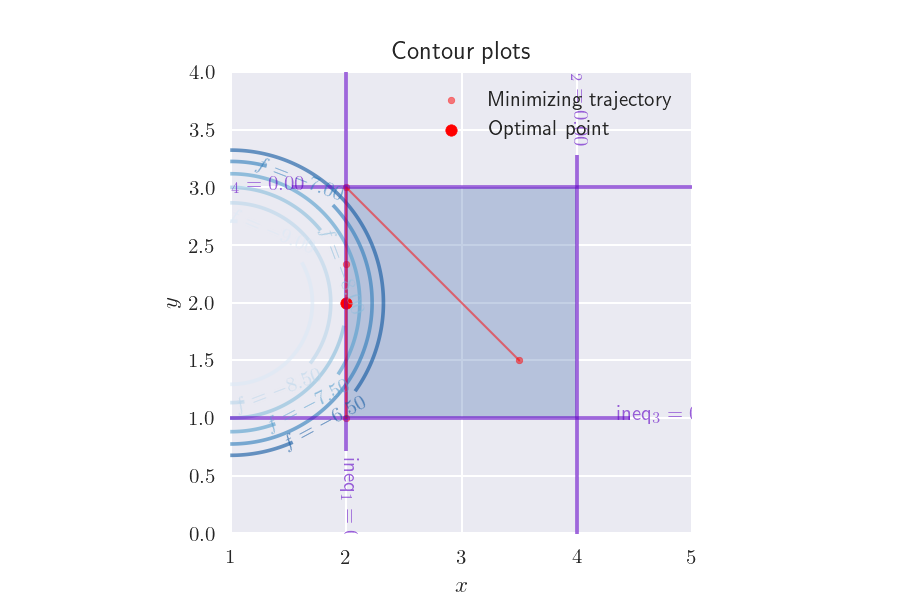

In [11]:
fig, ax = plot_contours(f, xx, yy, [-9, -8.5, -8, -7.5, -7, -6.5], constraints)
ax.plot(x_hist, y_hist, c='r', linewidth=1, alpha=0.5)
ax.scatter(x_hist, y_hist, c='r', s=10, alpha=0.5, label='Minimizing trajectory')
ax.scatter(*res.x, c='r', s=30, label='Optimal point')
ax.legend();